In [1]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
minSemesters = 2
maxSemesters = 5

difficulty = {
    'C1':4,
    'C2':4,
    'C3':4,
    'CT':3,
    'ADS':3,
    'ADS2':3,
    'DM':4,
    'P1':3,
    'NFI1':1,
    'NFI2':1,
    'SE':2,
    'OS':2
}

courses=[i for i in difficulty]

prereq = {
    'C2':['C1'],
    'C3':['C2'],
    'ADS':['CT'],
    'ADS':['ADS2'],
    'P1':['OS','SE']
}

def is_valid(ind):
    for course in ind:
        if course in prereq:
            for pre in prereq[course]:
                if ind[course] <= ind[pre]:
                    return False
    return True 


In [3]:
def create_individual():
    ind = {}
    placed = set()
    pending = [c for c in courses if c not in prereq]  # courses without prereqs
    n_sem = random.randint(minSemesters, maxSemesters)

    while pending:
        course = random.choice(pending)
        pending.remove(course)
        # Asignar cursos según su prerrequisito
        if course in prereq:
            min_sem = max(ind[p] for p in prereq[course]) + 1
        else:
            min_sem = 1
            
        sem = random.randint(min_sem, n_sem) if min_sem <= n_sem else n_sem
        ind[course] = sem

        placed.add(course)

        # Habilitar cursos con prerrequisitos
        for c in courses:
            if c not in placed and c not in pending:
                if all(p in placed for p in prereq.get(c, [])):
                    pending.append(c)

    return ind

def create_population(size=15):
    return [create_individual() for _ in range(size)]


In [4]:
def fitness(ind):
    n_sem = -1
    semesters = {}
    score = 200

    for course, sem in ind.items():
        n_sem = max(sem, n_sem)
        if course in prereq:
            for pre in prereq[course]:
                # Penalizar individuos invalidos
                if sem <= ind[pre]:
                    score -= 200
                else:
                # Penalizar por diferencia entre semestres de prerrequisito
                    score -= (sem - ind[pre] - 1)*2

        # Dividir individuo por semestres
        semesters.setdefault(sem, []).append(course)

    median_count = len(courses)/n_sem
    median_load = sum(difficulty.values())/n_sem
    course_counts = [len(c) for c in semesters.values()]

    # Penalizar por desviación de promedio de materias semestrales
    for count in course_counts:
        score -= abs(count - median_count) * 5

    # Penalizar por desviación de promedio de carga semestral
    for c in semesters.values():
        load = sum([difficulty[i] for i in c])
        score -= abs(load - median_load) * 3

    return round(score)

In [5]:
def selection(population):
    a, b = random.sample(population, 2)
    return a if fitness(a) > fitness(b) else b

def mutate(ind, prob=0.2):
    if random.random() < prob:
        n_sem = max(ind.values())
        random_key = random.choice(list(ind.keys()))
        ind[random_key] = random.randint(1, n_sem)
    return ind

def crossover(parent1, parent2):
    child = {}
    for course in parent1.keys():
        child[course] = parent1[course] if random.random() < 0.5 else parent2[course]
    return child

In [6]:
def evolve(population, generations=30):
    for gen in range(generations):
        new_pop = []
        for _ in range(len(population)):
            p1 = selection(population)
            p2 = selection(population)
            child = crossover(p1, p2)
            child = mutate(child)
            new_pop.append(child)

        population = new_pop
        best = max(population, key=fitness)
        print(f"Gen {gen+1:2d} | Fitness: {fitness(best)}")
    return best

In [7]:
population = create_population()
best = evolve(population)

Gen  1 | Fitness: 150
Gen  2 | Fitness: 122
Gen  3 | Fitness: 152
Gen  4 | Fitness: 152
Gen  5 | Fitness: 144
Gen  6 | Fitness: 152
Gen  7 | Fitness: 160
Gen  8 | Fitness: 166
Gen  9 | Fitness: 173
Gen 10 | Fitness: 169
Gen 11 | Fitness: 171
Gen 12 | Fitness: 173
Gen 13 | Fitness: 173
Gen 14 | Fitness: 179
Gen 15 | Fitness: 179
Gen 16 | Fitness: 179
Gen 17 | Fitness: 179
Gen 18 | Fitness: 179
Gen 19 | Fitness: 179
Gen 20 | Fitness: 179
Gen 21 | Fitness: 179
Gen 22 | Fitness: 179
Gen 23 | Fitness: 179
Gen 24 | Fitness: 179
Gen 25 | Fitness: 179
Gen 26 | Fitness: 179
Gen 27 | Fitness: 179
Gen 28 | Fitness: 179
Gen 29 | Fitness: 179
Gen 30 | Fitness: 179


In [8]:
semesters = defaultdict(list)
for course, sem in best.items():
    semesters[sem].append(course)

print("Mejor solución" + " válida " if is_valid(best) else " no válida" + " hallada ")
for semester, c in semesters.items():
    print(f"\nSemestre {semester}:{c}")

Mejor solución válida 

Semestre 1:['NFI1', 'DM', 'NFI2']

Semestre 3:['C1', 'ADS']

Semestre 2:['OS', 'ADS2', 'SE']

Semestre 5:['CT', 'C3']

Semestre 4:['C2', 'P1']


In [9]:
import matplotlib.pyplot as plt
from collections import defaultdict

def visualize_individual(ind, title="Mejor Pénsum"):
    # Agrupar cursos
    semesters = defaultdict(list)
    for course, sem in ind.items():
        semesters[sem].append(course)

    max_sem = max(semesters.keys())

    # Sort semesters
    ordered = [semesters[i] for i in range(1, max_sem+1)]

    # Find maximum courses in any semester (for equal table width)
    max_courses = max(len(s) for s in ordered)

    # Create table data with padding
    table_data = []
    for i, sem_courses in enumerate(ordered, start=1):
        row = [f"Semestre {i}"]
        for c in sem_courses:
            row.append(f"{c} ({difficulty[c]})")
        # pad with blanks so all rows are same length
        while len(row) < max_courses + 1:
            row.append("")
        table_data.append(row)

    # Crear figura
    fig, ax = plt.subplots(figsize=(12, max_sem*1.2))
    ax.axis("off")

    table = ax.table(
        cellText=table_data,
        cellLoc="center",
        loc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    ax.set_title(title, fontsize=14, fontweight="bold")
    #plt.savefig("GA-Ejemplo.png")
    plt.show()


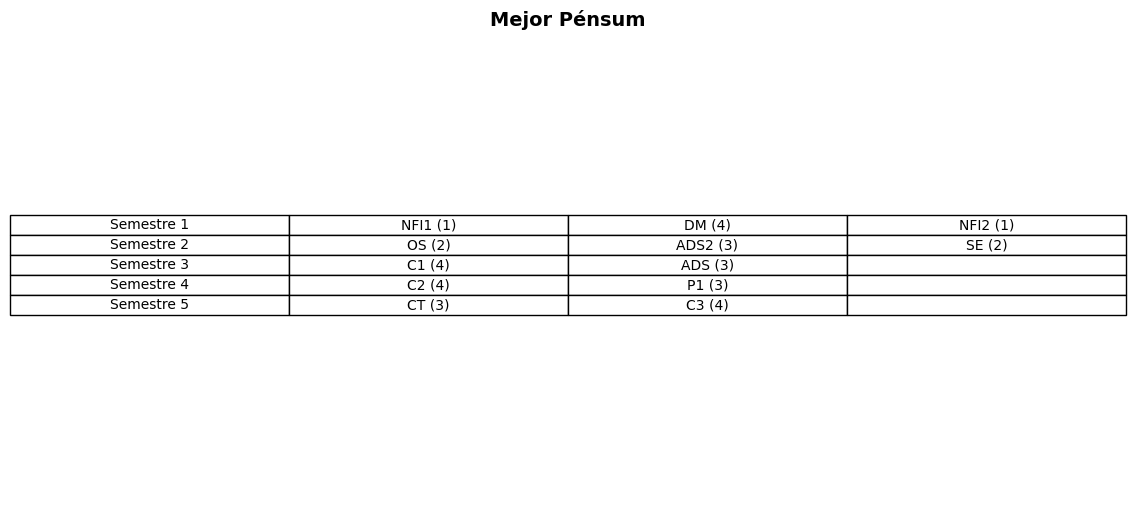

In [10]:
visualize_individual(best)